In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base =automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys() 

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement 
Station = Base.classes.station


In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
recent_date

'2017-08-23'

In [10]:
#used to see columns
first_row = session.query(Station).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x24e97665cc8>,
 'id': 1,
 'name': 'WAIKIKI 717.2, HI US',
 'longitude': -157.8168,
 'latitude': 21.2716,
 'station': 'USC00519397',
 'elevation': 3.0}

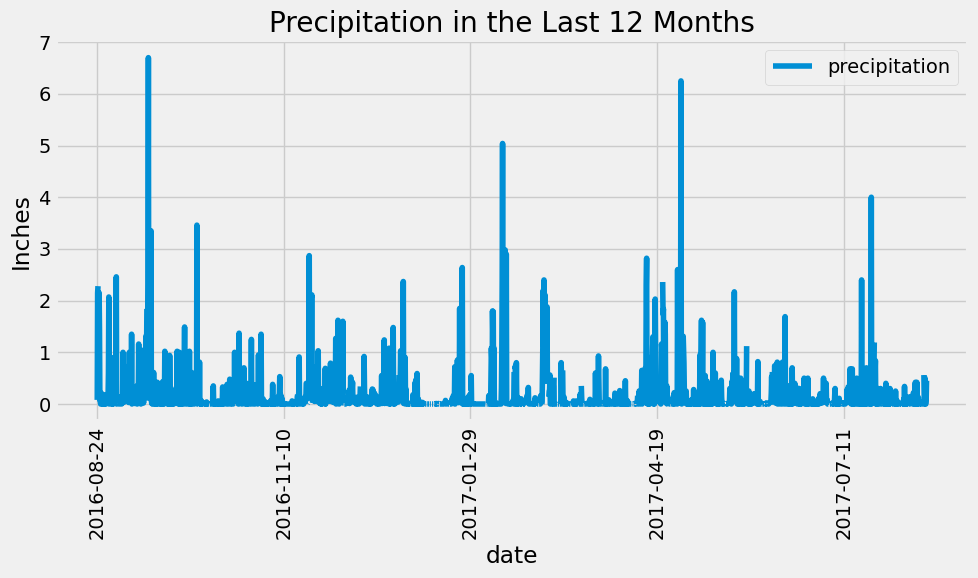

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
recent_date = dt.datetime.strptime(recent_date, '%Y-%m-%d')
year_ago = recent_date - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
precip_data = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= year_ago).order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precip_df = pd.DataFrame(precip_data, columns=['date', 'precipitation'])

# Sort the dataframe by date
precip_df.set_index('date', inplace=True)
precip_df.sort_index(inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
precip_df.plot(figsize=(10,6), rot=90)
plt.title('Precipitation in the Last 12 Months')
plt.ylabel('Inches')
plt.tight_layout()
plt.savefig('images/precipitation.png')
plt.show()

In [12]:
# Use Pandas to calculate the summary statistics for the precipitation data
precip_df.describe()

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [13]:
# Design a query to calculate the total number of stations in the dataset
session.query(func.count(Station.station)).all()

[(9,)]

In [14]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
sel =[Measurement.station, func.count(Measurement.station)]

stations_active= session.query(*sel).group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()
stations_active

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [15]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
sel = [func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)]
most_act_station = session.query(*sel).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.id).desc()).first()
most_act_station

(54.0, 85.0, 71.66378066378067)

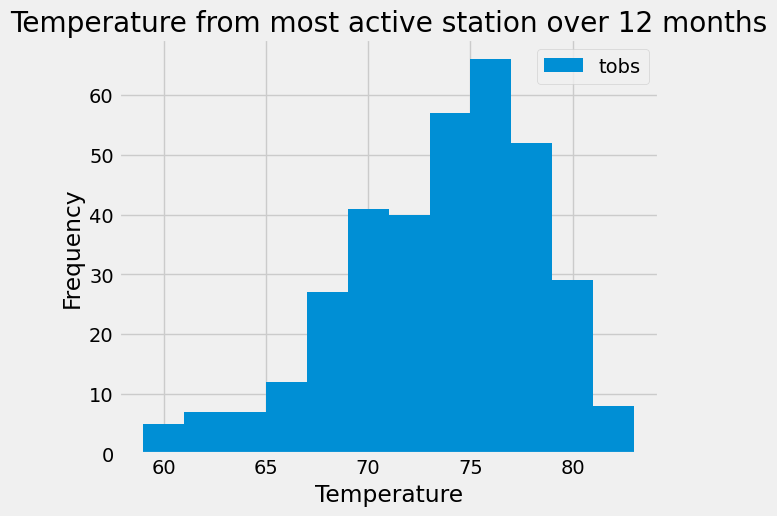

In [19]:
# Using the most active station id 'USC00519281' = stations_active[0][0]
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
results = session.query(Measurement.tobs).\
    filter(Measurement.station == stations_active[0][0]).\
    filter(Measurement.date >= year_ago).all()

# Convert the results to a DataFrame
df = pd.DataFrame(results, columns=['tobs'])

# Plot the results as a histogram
df.plot.hist(bins=12, alpha=1)
plt.tight_layout()
plt.xlabel("Temperature")
plt.title(f"Temperature from most active station over 12 months")
plt.savefig('images/tobs_histogram.png')
plt.show()

# Close Session

In [59]:
# Close Session
session.close()